### Import & Install Modules

In [1]:
!pip install graphviz
!pip install pydotplus
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from collections import Counter
import calendar
import datetime
import warnings

#NLTK stuff
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import *

#SKLearn stuff
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree

from sklearn.model_selection import train_test_split
from gensim.models import word2vec

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvass\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
warnings.filterwarnings("ignore")

In [4]:
#Read data from both provided CSV files
election_data = pd.read_csv('Canadian_elections_2019.csv')
twitter_data = pd.read_csv('generic_tweets.txt')

# Question 1: Data Cleaning
### Clean Canadian Elections Data

In [5]:
#Cleaning Canadian_elections_2019.csv file
text_list = []

stop_words = set(stopwords.words('english'))

for row in election_data['text']:
    
    text = re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/[\w\.-\/]+[\s])|(http:\/\/[\w\.-\/]+[\s])|(#)|(â)','',row) #Remove html attributes 
    text = re.sub(r"http\S+", "", text) #Remove URL
    text = re.sub('([^\w]+)',' ',text) #Remove punctuation
    text = re.sub('(\s)x\w+|xe2',' ',text) #Remove emojis
    text = text.lower() #Lowercase all characters
    tokenizer = RegexpTokenizer(r'\w+') #Setup tokenizer          
    token = tokenizer.tokenize(text) #Tokenize words in string
    text = [word for word in token if word not in stop_words] #Remove stop words
    
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text] #Stem 
    text_list.append(' '.join(text))

election_data['clean_text'] = pd.DataFrame(text_list)
election_data.head()

,sentiment,negative_reason,text,clean_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",b instead suggest agre canadian women trust an...
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",b allwomanspacewalk real n netobicokenorth cit...
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",b brantford go cost 94 billion next 4 year ask...
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",b canada canadaelection2019 canadavot nelxn43 ...
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",b canada taxpay sick amp tire hard earn donat ...


### Clean General Twitter Data

In [6]:
#Cleaning Canadian_elections_2019.csv file
twitter_list = []

stop_words = set(stopwords.words('english'))

for row in twitter_data['text']:
    
    twitter_text = re.sub('(@[\w]+)|(^rt\s+)|(http[s]:\/\/[\w\.-\/]+[\s])|(http:\/\/[\w\.-\/]+[\s])|(#)|(â)','',row) #Remove html attributes 
    twitter_text = re.sub(r"http\S+", "", twitter_text) #Remove URL
    twitter_text = re.sub('([^\w]+)',' ',twitter_text) #Remove punctuation
    twitter_text = re.sub('(\s)x\w+|xe2',' ',twitter_text) #Remove emojis
    twitter_text = twitter_text.lower() #Lowercase all characters
    twitter_tokenizer = RegexpTokenizer(r'\w+') #Setup tokenizer          
    twitter_token = twitter_tokenizer.tokenize(twitter_text) #Tokenize words in string
    twitter_text = [word for word in twitter_token if word not in stop_words] #Remove stop words
    
    ps = PorterStemmer()
    twitter_text = [ps.stem(word) for word in twitter_text] #Stem 
    twitter_list.append(' '.join(twitter_text))

twitter_data['clean_text'] = pd.DataFrame(twitter_list)
twitter_data.head()

,class,id,date,query,user,text,clean_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50 rest go bound
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behav mad see


# Question 2: Exploratory Analysis

## Part I: Segregating Parties

In order to segregate each party into 'Liberal', 'Conservative', 'NDP', or 'None', the program is looking at the cleaned text from part 1 and searching for positive and negative tweets.  If the text contains positive tweets about a particular party and negative tweets about others, it will categorize that party into one of the 4 buckets.  If the program is not able to identify the stance of a text, it will categorize it as 'None'.

The words or hashtags added to each list pertaining to a particular party represent the most frequent tokens used by the people who were posting about the election. 

In [7]:
party_list = []

conservative_list = ['scheer4pm','cpc','scheermajority','scheer','conservative',
                     'scheerhypocrisy','neverscheer','scheerlies','stopscheer',
                     'scheerdisaster','kinsellagate','jkenney','andrewscheer',
                     'andrew scheer','kinsella','conservatives','andrew']

liberal_list = ['teamtrudeau','voteliberal','chooseforward','lpc','liberalgovernment',
                'teamliberal','trudeau','liberal','trudeaumustgo','trudeaublackface',
                'trudeauthehypocrite','canadadeservesbetter','liberalparty',
                'justintrudeau','justin trudeau','votingliberal','liberals','justin']

ndp_list = ['thejagmeetsingh','uprisingh','votendp','ndp','singhsurge','imwithjagmeet',
            'iamwithjagmeet','risingh','jagmeet singh','singh','new democratic party',
            'keepsinghintheground','jagmeetsingh','jagmeet']

for tweet in text_list:
    
    countc = 0
    countl = 0
    countn = 0
    
    for word in tweet.split():
        if word in conservative_list:
            countc += 1
        elif word in liberal_list:
            countl += 1
        elif word in ndp_list:
            countn += 1
    
    if countc > max(countl, countn):
        party_list.append("Conservative")
        
    elif countl > max(countc, countn):
        party_list.append("Liberal")
        
    elif countn > max(countc, countl):
        party_list.append("NDP")
        
    elif countc == 0 and countl == 0 and countn == 0:
        party_list.append("None")
        
print(f"Party List: {list(Counter(party_list).keys())}") # equals to list(set(words))
print(f"Party Count: {list(Counter(party_list).values())}") # counts the elements' frequency

election_data['representative_party'] = pd.DataFrame(party_list)

Party List: ['None', 'Liberal', 'NDP', 'Conservative']
Party Count: [1336, 282, 128, 319]


### Dataframe Containing New Information

In [8]:
election_data.head(-1)

,sentiment,negative_reason,text,clean_text,representative_party
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",b instead suggest agre canadian women trust an...,None
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",b allwomanspacewalk real n netobicokenorth cit...,None
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",b brantford go cost 94 billion next 4 year ask...,Liberal
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",b canada canadaelection2019 canadavot nelxn43 ...,None
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",b canada taxpay sick amp tire hard earn donat ...,Liberal
5,negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",b canadavotes2019 elxn43 cdnpoli fact blastfro...,None
6,positive,NaN,"b""#CDNmedia #elxn43 #cdnpoli #PPC Rocky Dong h...",b cdnmedia elxn43 cdnpoli ppc rocki dong hand ...,None
7,positive,NaN,"b""#cdnpoli #elxn43 The Liberals ++ more than d...",b cdnpoli elxn43 liber doubl promis 2015 natio...,NDP
8,negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",b chooseforward cdnpoli elxn43 ncanada make am...,Liberal
9,negative,Scandal,"b""#CPCKinsellaGate\nLet's see the receipts. Wh...",b cpckinsellag nlet see receipt pay warren kin...,Conservative


## Part II: Exploratory Analysis of Data through Graphs

In [9]:
def plot_sentiment_histogram(election_data):
    #Condense List
    election_data_condensed = election_data.drop(['negative_reason', 'text','clean_text'], axis=1)
    election_data_condensed['combined_measures'] = election_data_condensed['sentiment'] + election_data_condensed['representative_party']
    election_data_condensed2 = election_data_condensed.drop_duplicates()
    election_data_condensed2 = election_data_condensed2.dropna() 

    sentiment_list = list(election_data_condensed2['sentiment'])
    representative_party_list = list(election_data_condensed2['representative_party'])

    #Count unique values
    election_data_count = pd.value_counts(election_data_condensed['combined_measures'])
    election_data_count = pd.DataFrame(election_data_count)
    count_list = list(election_data_count['combined_measures'])
    count_list

    #Combining datasets
    data = {"sentiment":sentiment_list,"representative_party": representative_party_list,"count": count_list}
    df = pd.DataFrame(data)
    df

    #Plotting the data
    a4_dims = (10, 6)
    fig, ax = pyplt.subplots(figsize=a4_dims)
    sns.barplot(x='representative_party', y='count',data = df,hue = 'sentiment').set_title("Count of Sentimental Tweets Per Political Party")


### Canadian 2019 Elections 

The histogram below classifies sentiment by political party.  It is calculated by tallying the total number of mentions for each party, extracting the maximum count of the tweet for a particular party, and comparing that value against the negative or positive sentiment of the tweet.  

- The data shows that the majority of the political tweets were either not directed to any party in particular, or directed to a party not part of the primary 3.  Interestingly, most of these tweets had a negative sentiment. 

- Of the tweets that were directed to a party, it was found that the Liberals had the most negative sentiments, while the NDP's had the least. 

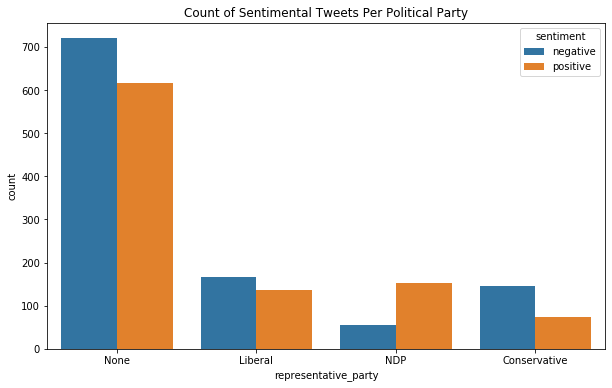

In [10]:
plot_sentiment_histogram(election_data)

In [11]:
def plot_general_tweets():
    twitter_data['day_of_week'] = twitter_data['date'].str[:3]
    twitter_data['date'] = pd.to_datetime(twitter_data['date'])
    twitter_data['month'] = pd.DatetimeIndex(twitter_data['date']).month
    twitter_data['month'] = twitter_data['month'].apply(lambda x: calendar.month_abbr[x])

    #Plotting the data
    a4_dims = (10, 6)
    fig, ax = pyplt.subplots(figsize=a4_dims)
    sns.countplot(y='day_of_week', data = twitter_data,hue = 'month',palette=["C0", "C9"]).set_title("Count of Tweets on DOW for April & May")


### General Tweet Data

The histogram below measures the count of tweets on a given day of the week for the months of April and May.  The purpose of analyzing this trend is to gauge what days of the week people are more likely update their Twitter accounts by making a post.

It was found that the majority of tweets from the sample data were actually sent out over the weekend, particularly on a Sunday.  

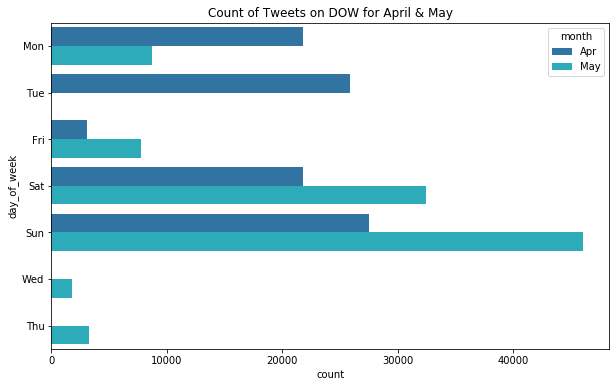

In [12]:
plot_general_tweets()

# Question 3: Model Preparation
## Part I: TF-IDF

Part I will look at using a TF-IDF vectorizer.

### Preparing the Data with TF-IDF Vectorizer

The number of features was kept relatively low (only 200) because I kept encountering a Memory Error if I went higher.  Regardless, it can be assumed that if the feature set was increased, the test accuracies and F1 scores would also increase.

In [13]:
#Initialze TF-IDF vecotorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))

X = twitter_data['clean_text']
y = twitter_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

### Logistic Regression (TF-IDF)

In [14]:
scaler = StandardScaler()
LR_tfidf_train = scaler.fit_transform(tfidf_train)
LR_tfidf_test = scaler.transform(tfidf_test)

LR= LogisticRegression()
LR.fit(LR_tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
LR_train_predictions = LR.predict(LR_tfidf_train)
LR_test_predictions = LR.predict(LR_tfidf_test)

In [16]:
accuracy_train = metrics.accuracy_score(y_train, LR_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, LR_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.28%
Test Accuracy: 69.23%


### K-Nearest Neighbour (TF-IDF)

In [17]:
# KNN = KNeighborsClassifier(n_neighbors=3)
# KNN = KNN.fit(tfidf_train, y_train) 
# KNN_test_predictions = KNN.predict(tfidf_test)

In [18]:
accuracy_test= metrics.accuracy_score(y_test, KNN_test_predictions)
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Test Accuracy: 62.44%


### Naive Bayes (TF-IDF)

In [19]:
NB = MultinomialNB()
NB = NB.fit(tfidf_train,y_train)
NB_test_predictions = NB.predict(tfidf_test)
NB_train_predictions = NB.predict(tfidf_train)

In [20]:
accuracy_train = metrics.accuracy_score(y_train, NB_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, NB_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 68.57%
Test Accuracy: 68.22%


### Linear SVM (TF-IDF)

In [21]:
SVC = LinearSVC()
SVC.fit(tfidf_train, y_train) 
SVC_test_predictions = SVC.predict(tfidf_test)
SVC_train_predictions = SVC.predict(tfidf_train)

In [22]:
accuracy_train = metrics.accuracy_score(y_train, SVC_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, SVC_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.22%
Test Accuracy: 69.15%


### Decision Trees (TF-IDF)

In [23]:
DT = DecisionTreeClassifier()
DT = DT.fit(tfidf_train, y_train)
DT_test_predictions = SVC.predict(tfidf_test)
DT_train_predictions = SVC.predict(tfidf_train)

In [24]:
accuracy_train = metrics.accuracy_score(y_train, DT_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, DT_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.22%
Test Accuracy: 69.15%


### Random Forest (TF-IDF)

In [32]:
RF = RandomForestClassifier()
RF = RF.fit(tfidf_train, y_train)
RF_test_predictions = RF.predict(tfidf_test)
RF_train_predictions = RF.predict(tfidf_train)

In [33]:
accuracy_train = metrics.accuracy_score(y_train, RF_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, RF_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 83.23%
Test Accuracy: 67.10000000000001%


### XG-Boost (TF-IDF)

In [34]:
XGB = XGBClassifier()
XGB = XGB.fit(tfidf_train, y_train)
XGB_test_predictions = XGB.predict(tfidf_test)
XGB_train_predictions = XGB.predict(tfidf_train)

In [35]:
accuracy_train = metrics.accuracy_score(y_train, XGB_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, XGB_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 66.95%
Test Accuracy: 66.75999999999999%


## Part II: Bag-Of-Words

Part II will look at using Bag of words count vectorizer.

### Preparing the Data with Count Vectorizer

The number of features was kept relatively low (only 200) because I kept encountering a Memory Error if I went higher.  Regardless, it can be assumed that if the feature set was increased, the test accuracies and F1 scores would also increase.

In [36]:
#Initialze TF-IDF vecotorizer
bow_vectorizer = CountVectorizer(stop_words = "english", max_features= 200, ngram_range= (1,2))

bow_train = bow_vectorizer.fit_transform(X_train)
bow_test = bow_vectorizer.transform(X_test)

bow_train = bow_train.toarray()
bow_test = bow_test.toarray()

### Logistic Regression (BOW)

In [37]:
scaler = StandardScaler()
LR_bow_train = scaler.fit_transform(bow_train)
LR_bow_test = scaler.transform(bow_test)

LR = LogisticRegression()
LR.fit(LR_bow_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
LR_train_predictions = LR.predict(LR_bow_train)
LR_test_predictions = LR.predict(LR_bow_test)

In [39]:
accuracy_train = metrics.accuracy_score(y_train, LR_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, LR_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.26%
Test Accuracy: 69.19%


### K-Nearest Neighbour (BOW)

In [ ]:
# KNN = KNeighborsClassifier(n_neighbors=3)
# KNN = KNN.fit(bow_train, y_train) 
# KNN_test_predictions = KNN.predict(bow_test)

In [ ]:
accuracy_test= metrics.accuracy_score(y_test, KNN_test_predictions)
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

### Naive Bayes (BOW)

In [41]:
NB = MultinomialNB()
NB = NB.fit(bow_train,y_train)
NB_test_predictions = NB.predict(bow_test)
NB_train_predictions = NB.predict(bow_train)

In [42]:
accuracy_train = metrics.accuracy_score(y_train, NB_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, NB_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 68.51%
Test Accuracy: 68.27%


### Linear SVM (BOW)

In [43]:
SVC = LinearSVC()
SVC.fit(bow_train, y_train) 
SVC_test_predictions = SVC.predict(bow_test)
SVC_train_predictions = SVC.predict(bow_train)

In [44]:
accuracy_train = metrics.accuracy_score(y_train, SVC_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, SVC_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.21000000000001%
Test Accuracy: 69.15%


### Decision Trees (BOW)

In [45]:
DT = DecisionTreeClassifier()
DT = DT.fit(bow_train, y_train)
DT_test_predictions = SVC.predict(bow_test)
DT_train_predictions = SVC.predict(bow_train)

In [46]:
accuracy_train = metrics.accuracy_score(y_train, DT_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, DT_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 69.21000000000001%
Test Accuracy: 69.15%


### Random Forest (BOW)

In [47]:
RF = RandomForestClassifier()
RF = RF.fit(bow_train, y_train)
RF_test_predictions = RF.predict(bow_test)
RF_train_predictions = RF.predict(bow_train)

In [48]:
accuracy_train = metrics.accuracy_score(y_train, RF_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, RF_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 83.32000000000001%
Test Accuracy: 66.47999999999999%


### XG-Boost (BOW)

In [49]:
XGB = XGBClassifier()
XGB = XGB.fit(bow_train, y_train)
XGB_test_predictions = XGB.predict(bow_test)
XGB_train_predictions = XGB.predict(bow_train)

In [50]:
accuracy_train = metrics.accuracy_score(y_train, XGB_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, XGB_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 66.56%
Test Accuracy: 66.47999999999999%


## Part III: Discussion of Results

The data below was tallied and added to 2 separate dataframes: 1 for using the TF-IDF vectorizer, and the other for using the bag-of-words model.

In [51]:
def create_tfidf_table():
    
    ml_algorithm = ["logistic_regression","k_nearest_neighbour",
                    "naive_bayes","linear_svm","decision_tree",
                    "random_forest","xg_boost"]

    train_results = [69.28,"--",68.57,69.22,69.22,83.25,66.95]
    test_results = [69.23,62.44,68.22,69.15,69.15,67.22,66.76]

    combined_table = [ml_algorithm,train_results,test_results]

    tfidf_data = pd.DataFrame(list(zip(ml_algorithm, train_results, test_results)), 
                      columns =['ml_algorithm', 'train_results','test_results']) 
    return tfidf_data

In [52]:
def create_bow_table():
    
    ml_algorithm = ["logistic_regression","k_nearest_neighbour",
                    "naive_bayes","linear_svm","decision_tree",
                    "random_forest","xg_boost"]

    train_results = [69.26,"--",68.51,69.22,69.22,85.50,66.56]
    test_results = [69.19,62.34,68.27,69.15,69.15,66.36,66.48]

    combined_table = [ml_algorithm,train_results,test_results]

    bow_data = pd.DataFrame(list(zip(ml_algorithm, train_results, test_results)), 
                      columns =['ml_algorithm', 'train_results','test_results']) 
    return bow_data

### TF-IDF Data

In [53]:
create_tfidf_table()

,ml_algorithm,train_results,test_results
0,logistic_regression,69.28,69.23
1,k_nearest_neighbour,--,62.44
2,naive_bayes,68.57,68.22
3,linear_svm,69.22,69.15
4,decision_tree,69.22,69.15
5,random_forest,83.25,67.22
6,xg_boost,66.95,66.76


### Bag-Of-Words Data

In [54]:
create_bow_table()

,ml_algorithm,train_results,test_results
0,logistic_regression,69.26,69.19
1,k_nearest_neighbour,--,62.34
2,naive_bayes,68.51,68.27
3,linear_svm,69.22,69.15
4,decision_tree,69.22,69.15
5,random_forest,85.5,66.36
6,xg_boost,66.56,66.48


From the results of the test, it can be seen that most algorithms are comparable.  That being said, it was found that SVM and KNN were extremely computationally expensive and took quite a while to run.  As a result, the best model for the analysis is Logistic Regression under the TF-IDF Vectorizer.

The next tep in this analysis is to determine the best hyperparameters to use under LR TF-IDF.  This will be tested on the General Tweets data, and implemented on the Election Data in Question 4 below.

# Question 4: Model Implementation

## Part I: Training the Model on GT Data and Testing on Elections Data

The program below tests a different number of features so best predict the accuracy.

In [55]:
X = twitter_data['clean_text']
y = twitter_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for i in range(500,5001,500):
    try:
        #Initialize TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= i, ngram_range= (1,2))
        tfidf_train = tfidf_vectorizer.fit_transform(X_train)
        tfidf_test = tfidf_vectorizer.transform(X_test)

        #Initialize Logistic Regression
        LR = LogisticRegression()
        LR.fit(tfidf_train,y_train)
        LR_test_predictions = LR.predict(tfidf_test)

        #Calculate accuracies
        accuracy_test= metrics.accuracy_score(y_test, LR_test_predictions)
        print(f"Test Accuracy: {round(accuracy_test,4)*100}% At {i} features")
        
    except:
        print(f"Memory Error at {i} features")

Test Accuracy: 72.39999999999999% At 500 features
Test Accuracy: 74.08% At 1000 features
Test Accuracy: 74.76% At 1500 features
Test Accuracy: 75.2% At 2000 features
Test Accuracy: 75.47% At 2500 features
Test Accuracy: 75.59% At 3000 features
Test Accuracy: 75.67% At 3500 features
Test Accuracy: 75.66000000000001% At 4000 features
Test Accuracy: 75.7% At 4500 features
Test Accuracy: 75.8% At 5000 features


The program below tests different hyperparameters to best predict the accuracy

In [56]:
for p in [0.001,0.01,0.1,1,10]:

        #Initialize TF-IDF vectorizer
        tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 2500, ngram_range= (1,2))
        tfidf_train = tfidf_vectorizer.fit_transform(X_train)
        tfidf_test = tfidf_vectorizer.transform(X_test)

        #Initialize Logistic Regression
        LR = LogisticRegression(C = p, solver='lbfgs',multi_class='multinomial')
        LR.fit(tfidf_train,y_train)
        LR_test_predictions = LR.predict(tfidf_test)

        #Calculate accuracies
        accuracy_test= metrics.accuracy_score(y_test, LR_test_predictions)
        print(f"Test Accuracy: {round(accuracy_test,4)*100}% At C = {p}")

Test Accuracy: 71.99% At C = 0.001
Test Accuracy: 73.95% At C = 0.01
Test Accuracy: 75.26% At C = 0.1
Test Accuracy: 75.39% At C = 1
Test Accuracy: 75.33999999999999% At C = 10


The data was chosen to function at 2500 features with C = 1.  After running the hyperparameters above, it was found that these values worked best.  While the accuracy kept increasing past 2500 features, this began to slow the iterative process down.  The increases were not significant, and so it is less computationally expensive to run the program at 2500 features. 

In [85]:
X = twitter_data['clean_text']
y = twitter_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 2500, ngram_range= (1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

#Initialize Logistic Regression
LR = LogisticRegression(C = 1, solver='lbfgs',multi_class='multinomial')
LR = LR.fit(tfidf_train,y_train)

In [86]:
X_election = election_data['clean_text']
y_election = election_data['sentiment']

y_election = y_election.replace('negative', 0)
y_election = y_election.replace('positive', 4)

#Initialize TF-IDF vectorizer
X_election = tfidf_vectorizer.fit_transform(X_election)
LR_test_predictions = LR.predict(X_election)

#Calculate accuracies
accuracy_test = metrics.accuracy_score(y_election, LR_test_predictions)
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Test Accuracy: 52.09%


## Part II: Calculating Accuracy for Each Party

### Liberal Party Data

In [87]:
lib_election_data = election_data[election_data['representative_party'] == "Liberal"]
X_led = lib_election_data['clean_text']
y_led = lib_election_data['sentiment']

y_led = y_led.replace('negative', 0)
y_led = y_led.replace('positive', 4)

#Initialize TF-IDF vectorizer
X_led = tfidf_vectorizer.fit_transform(X_led)
LR_test_predictions = LR.predict(X_led)

#Calculate accuracies
accuracy_test = metrics.accuracy_score(y_led, LR_test_predictions)
print(f"Test Accuracy for Liberal Party: {round(accuracy_test,4)*100}%")

Test Accuracy for Liberal Party: 54.26%


Text(0.5, 15.0, 'Predicted')

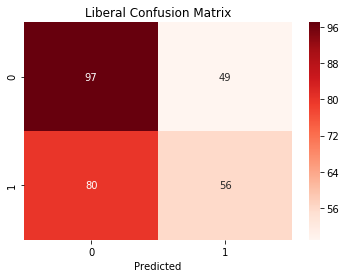

In [88]:
cm=confusion_matrix(y_led, LR_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Reds',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('Liberal Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

### Conservative Party Data

In [89]:
con_election_data = election_data[election_data['representative_party'] == "Conservative"]
X_ced = con_election_data['clean_text']
y_ced = con_election_data['sentiment']

y_ced = y_ced.replace('negative', 0)
y_ced = y_ced.replace('positive', 4)

#Initialize TF-IDF vectorizer
X_ced = tfidf_vectorizer.fit_transform(X_ced)
LR_test_predictions = LR.predict(X_ced)

#Calculate accuracies
accuracy_test = metrics.accuracy_score(y_ced, LR_test_predictions)
print(f"Test Accuracy for Conservative Party: {round(accuracy_test,4)*100}%")

Test Accuracy for Conservative Party: 50.470000000000006%


Text(0.5, 15.0, 'Predicted')

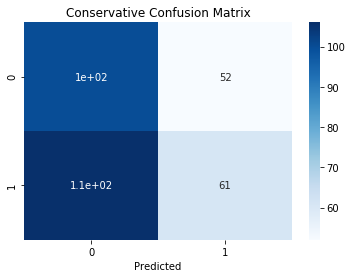

In [91]:
cm=confusion_matrix(y_ced, LR_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Blues',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('Conservative Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

### New Democratic Party Data

In [92]:
ndp_election_data = election_data[election_data['representative_party'] == "NDP"]
X_ned = ndp_election_data['clean_text']
y_ned = ndp_election_data['sentiment']

y_ned = y_ned.replace('negative', 0)
y_ned = y_ned.replace('positive', 4)

#Initialize TF-IDF vectorizer
X_ned = tfidf_vectorizer.fit_transform(X_ned)
LR_test_predictions = LR.predict(X_ned)

#Calculate accuracies
accuracy_test = metrics.accuracy_score(y_ned, LR_test_predictions)
print(f"Test Accuracy for NDP: {round(accuracy_test,4)*100}%")

Test Accuracy for NDP: 55.47%


Text(0.5, 15.0, 'Predicted')

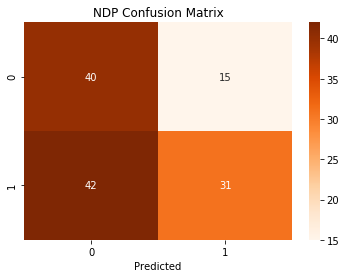

In [93]:
cm=confusion_matrix(y_ned, LR_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Oranges',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('NDP Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

## Part III: Calculating Accuracy for Negative Reasons

### Preparing the Data

In [62]:
negative_election_data = election_data[election_data['sentiment'] == 'negative']

X_election_text = negative_election_data['clean_text']
y_election_negative = negative_election_data['negative_reason']

### Plotting the Original Data
The histogram below shows the distribution of negative reasons for the negative sentiment data.  Because the data is non-even, this may throw off the accuracy when applying the 3 machine learning algorithms.  For instance, "Healthcare","Separation" and "Healthcare & Marijuana" are all extremely low when compared to other reasons.  In order to even out the distribution a little more, some reasons will need to be combined.

Text(0.5, 1.0, 'Count of Negative Reasons')

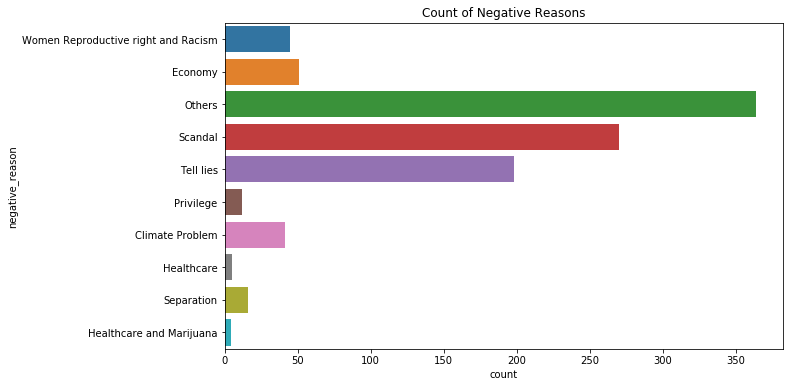

In [63]:
#Plotting the data
a4_dims = (10, 6)
fig, ax = pyplt.subplots(figsize=a4_dims)
sns.countplot(y='negative_reason', data = negative_election_data).set_title("Count of Negative Reasons")

In [64]:
y_election_negative = y_election_negative.replace('Healthcare', "Healthcare and Marijuana")
y_election_negative = y_election_negative.replace('Separation', 'Women Reproductive Rights, Racism, Separation and Privilege')
y_election_negative = y_election_negative.replace('Women Reproductive right and Racism', 'Women Reproductive Rights, Racism, Separation and Privilege')
y_election_negative = y_election_negative.replace('Privilege', 'Women Reproductive Rights, Racism, Separation and Privilege')

### Plotting the Manipulated Data

Some of the negative reasons that were more related to one another were categorized with each other. In theory, this will help to increase the accuracy of each Machine Learning algorithm tested.  

- "Women's Reproductive rights and Racism" were categorized with "Separation" and "Privilege".
- "Healthcare" and "Healthcare and Marijuana" were categorized together.

Text(0.5, 1.0, 'Count of Negative Reasons')

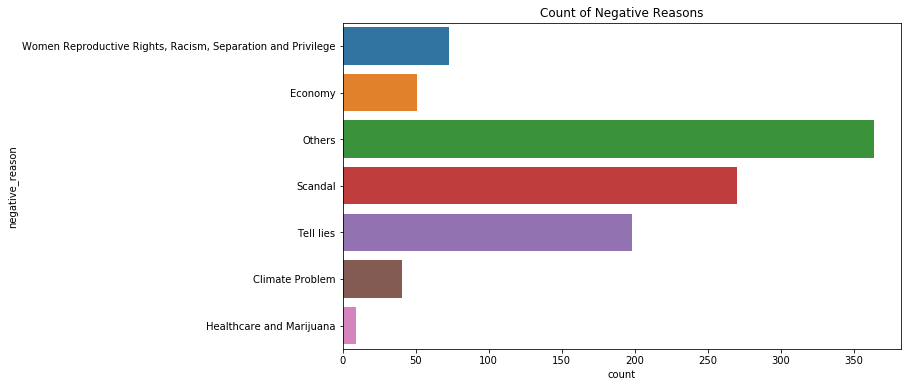

In [65]:
negative_election_data['negative_reason'] = y_election_negative

#Plotting the data
a4_dims = (10, 6)
fig, ax = pyplt.subplots(figsize=a4_dims)
sns.countplot(y='negative_reason', data = negative_election_data).set_title("Count of Negative Reasons")

### Splitting the Negative Data 70/30

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_election_text, y_election_negative, 
                                                    test_size=0.3, random_state=42)

In [67]:
tfidf_vectorizer = TfidfVectorizer(stop_words = "english", max_df=0.7, max_features= 200, ngram_range= (1,2))

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

### Logistic Regression

In [68]:
scaler = StandardScaler()
LR_tfidf_train = scaler.fit_transform(tfidf_train)
LR_tfidf_test = scaler.transform(tfidf_test)

LR= LogisticRegression()
LR.fit(LR_tfidf_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
LR_train_predictions = LR.predict(LR_tfidf_train)
LR_test_predictions = LR.predict(LR_tfidf_test)

In [70]:
accuracy_train = metrics.accuracy_score(y_train, LR_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, LR_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 88.92%
Test Accuracy: 52.32%


Text(0.5, 15.0, 'Predicted')

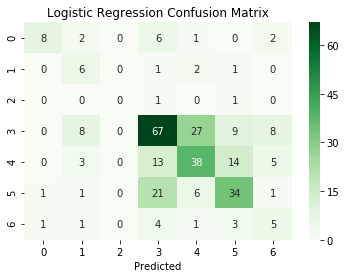

In [71]:
cm=confusion_matrix(y_test, LR_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Greens',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('Logistic Regression Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

### Naive Bayes

In [72]:
NB = MultinomialNB()
NB = NB.fit(tfidf_train,y_train)
NB_test_predictions = NB.predict(tfidf_test)
NB_train_predictions = NB.predict(tfidf_train)

In [73]:
accuracy_train = metrics.accuracy_score(y_train, NB_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, NB_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 62.93%
Test Accuracy: 50.0%


Text(0.5, 15.0, 'Predicted')

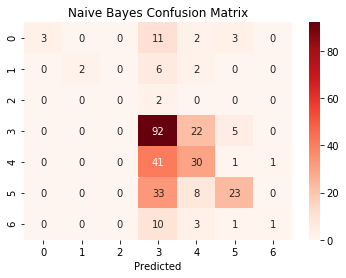

In [74]:
cm=confusion_matrix(y_test, NB_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Reds',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('Naive Bayes Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

### Linear SVM

In [75]:
SVC = LinearSVC()
SVC.fit(tfidf_train, y_train) 
SVC_test_predictions = SVC.predict(tfidf_test)
SVC_train_predictions = SVC.predict(tfidf_train)

In [76]:
accuracy_train = metrics.accuracy_score(y_train, SVC_train_predictions)
accuracy_test= metrics.accuracy_score(y_test, SVC_test_predictions)

print(f"Train Accuracy: {round(accuracy_train,4)*100}%")
print(f"Test Accuracy: {round(accuracy_test,4)*100}%")

Train Accuracy: 81.53%
Test Accuracy: 55.96%


Text(0.5, 15.0, 'Predicted')

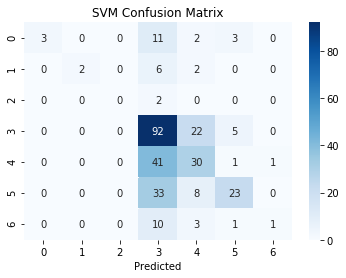

In [77]:
cm=confusion_matrix(y_test, NB_test_predictions)
heatmap_conf=sns.heatmap(cm,cmap='Blues',annot=True, annot_kws={'va':'center'})
heatmap_conf.set_title('SVM Confusion Matrix')
heatmap_conf.set_xlabel("Predicted")

### Discussion of Results

While the accuracies obtained across each algorithm were quite good (LR: 52.32%, NB: 50.0% and SVM: 55.96%), the 3 confusion matrices plotted above show that some classes have better True Positives and False Positives than others.  This is to be expected, because as per the plot above, after the data has been manipulated, it is clear that the distribution of negative reasons is not even.  For instance, when comparing "Others" to "Healthcare and Marijuana", their respective counts are 365 and 10.  As such, there is more data being trained on the "Others" class than "Healthcare and Marijuana" class.

Theoretically, if the classes were further condensed into fewer categories, the accuracy of each algorithm would increase.  This is however not desirable, because it would restrict the Machine Learning algorithm to pieces of data that have no relevance with each other, and so predicting the outcome of the election would be certain reasons would no longer make sense.  

# Question 5: Results

### Research Question

###### What can public opinion on Twitter tell us about the Canadian Political landscape in 2019?

## Part I: Discussion of Sentiments

The results of implementing the first machine learning algorithms in Question 3 allow us to determine whether a particular tweet was negatively or positively aimed at a specific party.  It can be assumed that positive tweets are more correlated to a higher probabaility of that person voting for that particular party.  The opposite can be assumed for any negative tweets.   

### Parties

- From the sample data, it can be seen that the Liberal party is relatively neutral.  The number of negative sentiments compared to positive sentiments is more or less equal.  It's also important to note that of the 3 major parties presented, the Liberals had the most tweets directed to them.

- The Conservative party mostly had negative tweets directed to them (just under double the number of negative tweets as compared to positive tweets).  It's also interesting to note that, while there weren't as many tweets directed to them as the Liberals, their number of negative tweets almost matches those of the Liberals.  This is saying a lot, as from the data and popular opinion of many Canadians, Andrew Scheer was not desirable as Prime Minister.

- The NDP's had mostly positive tweets directed at them, although when compared to the Liberals and Conservatives, the total number of Tweets was the lowest.  

- Not surprisingly, the most number of Tweets fell under the "None" category, which indicates that either other parties not part of the larger 3 were mentioned, or that no party in particular was mentioned.  This category contained mostly negative sentiments (although not by much) about the election in general.  It is much harder to gauge this category, as the data is not directed to a particular party.  

- One method of resolving this issue could be to extract the username of the person who published the Tweet, and analyze their other Tweets to gauge which party they are most supportive of (and vice versa).  Performing this analysis would theoretically reduce the number of "Nones" and contribute more to the actual data required in predicting a candidate.  


### Explanation of Confusion Matrices

While the accuracies in the data show potential, they are not as good as they can be.  The confusion matrices were plotted for each party and showed that there were many false predictions. An explanation for this could be that the amount of data containing "None" far outweighs the data for each party.  Because of this, there is some bias in predicting the sentiment.

- In order to reduce the number of false predictions and increase the accuracy, a further analysis on determining what Tweet is directed at what party could be looked into, in order to reduce the number of "None's".
- One other way of increasing the accuracy is to expose more party data to the model.  If there was a relatively more even distribution of parties in the dataset, the model could use this to make more accurate predictions.

## Part II: Discussion of Negative Reasons

### Reasons for Possible Model Failure

As discussed breifly in Question 4, the distribution count of negative reasons is extremely uneven.  It is difficult for the model to predict what the outcome of reason would be, when the dataset is biased towards particular classes and not others.

When comparing all 3 confusion matrices in Q4:PIII, it is clearly evident that model made extremely accurate predictions for some of the classes (particularly for Others, Scandal, and Tell Lies) and not at all for others.  As such, while the accuracy seems reasonable, it is biased towards only those classes.

This will cause a huge impact for when the model is trying to predict the type of reasoning, because there is too much exposure of data to some classes and not enough for others.  The model will easily mis-interpet classes in the sentiment analysis.

### Improving the Accuracy

There are a few things that can be done to the dataset in order to improve the model's accuracy:

- The first and most obvious way is to condense the number of similar classes.  For instance, "Healthcare and Marijuana" and "Healthcare" were originally 2 distinct classes in the unaltered dataset.  If both of these classes were combined into 1, the total number of classes would decrease and the model would be exposed to more data for this particular case.
- The second way to improve accuracy is to expose the model to more data that would help even the distribution of cases.  For example, there aren't many cases of "Privilege" in the dataset.  If there was more data pertaining to this particular class however, the outcome would be more accurate.
